In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
        
class EnergyStorage:
    def __init__(self, name, maxPower, initTermSOC, maxCapacity, chgEfficiency, disEfficiency):
        self.name = name
        self.maxPower = maxPower
        self.initSOC = initTermSOC[0]
        self.termSOC = initTermSOC[1]
        self.maxCapacity = maxCapacity
        self.chgEfficiency = chgEfficiency
        self.disEfficiency = disEfficiency

In [23]:
#계절별 가격표
spring_fall_price = [38.8 for i in range(9)]+[53.0]+[72.8 for i in range(2)]+[53.0]+[72.8 for i in range(4)]+[53.0 for i in range(6)]+[38.8]
summer_price = [38.8 for i in range(9)]+[82.3]+[145.2 for i in range(2)]+[82.3]+[145.2 for i in range(4)]+[82.4 for i in range(6)]+[38.8]
winter_price = [42.6 for i in range(9)]+[80.6]+[117.9 for i in range(2)]+[80.6 for i in range(5)]+[117.9 for i in range(3)]+[80.6 for i in range(2)]+[117.9, 42.6]
month = 11
if (6 <= month)&(month<=8):
    price = summer_price
elif (11<=month)|(month<=2):
    price = winter_price
else:
    price = spring_fall_price

### Load data
load = [30]*24

SOC_ESS_MIN = 0.2
SOC_ESS_MAX = 0.8
SOC_ESS_INIT = 0.5
SOC_ESS_TERM = 0.5
chgEfficiency = 1
disEfficiency = 0.93

gistEss = EnergyStorage('gistESS', 250, [SOC_ESS_INIT, SOC_ESS_TERM], 750, chgEfficiency, disEfficiency)

### Set number of variables
nTimeslot = len(load)

In [24]:
print((11<=month)&(month<=2))
print(price)

False
[42.6, 42.6, 42.6, 42.6, 42.6, 42.6, 42.6, 42.6, 42.6, 80.6, 117.9, 117.9, 80.6, 80.6, 80.6, 80.6, 80.6, 117.9, 117.9, 117.9, 80.6, 80.6, 117.9, 42.6]


In [25]:
##### MILP #####
# 최적화 변수들에는 기존에 정한 naming rule을 따르지 않고 보편적으로 사용되는 변수 알파벳을 사용
# 변수 알파벳 옆의 아래 첨자는 '_'를 이용해 표시했고 아래 첨자는 가능한 naming rule을 따름

m = Model(name='Unit Commitment')

### 변수 생성
P_essChg = m.continuous_var_list(nTimeslot, lb=0, ub=250)
P_essDis = m.continuous_var_list(nTimeslot, lb=0, ub=250)
U_essChg = m.binary_var_list(nTimeslot)
U_essDis = m.binary_var_list(nTimeslot)

### 제약조건
# 모든전원 최소 최대 출력 제약, ONOFF 제약, 수급균형 제약
for i in range(nTimeslot):
    m.add_constraint( P_essDis[i] <= U_essDis[i]*gistEss.maxPower )
    m.add_constraint( P_essChg[i] <= U_essChg[i]*gistEss.maxPower )
    m.add_constraint( U_essDis[i] + U_essChg[i] <= 1 )
    m.add_constraint( P_essDis[i] <= load[i] ) #부하 이상의 전력은 방전 불가.
    
# SOC 제약
    #충방전시 minMaxSOC 유지
for i in range(nTimeslot):
        m.add_constraint( gistEss.initSOC
                          - sum(P_essDis[k]/gistEss.disEfficiency/gistEss.maxCapacity
                                for k in range(i + 1))
                          + sum(P_essChg[k]*gistEss.chgEfficiency/gistEss.maxCapacity
                                for k in range(i + 1)) <=  SOC_ESS_MAX )
        m.add_constraint( gistEss.initSOC
                          - sum(P_essDis[k]/gistEss.disEfficiency/gistEss.maxCapacity
                                for k in range(i + 1))
                          + sum(P_essChg[k]*gistEss.chgEfficiency/gistEss.maxCapacity
                                for k in range(i + 1)) >=  SOC_ESS_MIN )
        
    #24시간 후 termSOC equal condition
m.add_constraint(gistEss.initSOC 
                 - sum(P_essDis[k]/gistEss.disEfficiency/gistEss.maxCapacity for k in range(nTimeslot))
                 + sum(P_essChg[k]*gistEss.chgEfficiency/gistEss.maxCapacity for k in range(nTimeslot))
                 ==  gistEss.termSOC )
    



docplex.mp.LinearConstraint[](0.001x1+0.001x2+0.001x3+0.001x4+0.001x5+0.001x6+0.001x7+0.001x8+0.001x9+0.001x10+0.001x11+0.001x12+0.001x13+0.001x14+0.001x15+0.001x16+0.001x17+0.001x18+0.001x19+0.001x20+0.001x21+0.001x22+0.001x23+0.001x24-0.001x25-0.001x26-0.001x27-0.001x28-0.001x29-0.001x30-0.001x31-0.001x32-0.001x33-0.001x34-0.001x35-0.001x36-0.001x37-0.001x38-0.001x39-0.001x40-0.001x41-0.001x42-0.001x43-0.001x44-0.001x45-0.001x46-0.001x47-0.001x48+0.500,EQ,0.5)

In [26]:
### 목적함수
m.set_objective("min", sum((load[i]+P_essChg[i]-P_essDis[i])*price[i] for i in range(24)))
                               
m.print_information()
sol = m.solve()
print(m.objective_value)

### Solution 저장

P_essDisSol = np.zeros([nTimeslot])
P_essChgSol = np.zeros([nTimeslot])
U_essDisSol = np.zeros([nTimeslot])
U_essChgSol = np.zeros([nTimeslot])

socEss = np.zeros([nTimeslot])
for i in range(nTimeslot):
        P_essDisSol[i] = sol.get_value(P_essDis[i])
        P_essChgSol[i] = sol.get_value(P_essChg[i])
        U_essDisSol[i] = sol.get_value(U_essDis[i])
        U_essChgSol[i] = sol.get_value(U_essChg[i])
        socEss[i] = (gistEss.initSOC 
                        - sum(P_essDisSol[k]/gistEss.disEfficiency/gistEss.maxCapacity for k in range(i + 1)) 
                        + sum(P_essChgSol[k]*gistEss.chgEfficiency/gistEss.maxCapacity for k in range(i + 1)))

Model: Unit Commitment
 - number of variables: 96
   - binary=48, integer=0, continuous=48
 - number of constraints: 145
   - linear=145
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
32070.9


[   0.     0.     0.     0.     0.     0.     0.     0.  -225.    30.
   30.    30.    30.    30.    30.    30.    30.    30.    30.    30.
   30.    28.5   30.  -225. ]
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


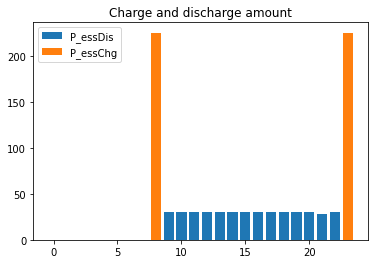

In [54]:
hours = np.arange(24)
fig, ax = plt.subplots()
ax.bar(hours, P_essDisSol, label='P_essDis')
ax.bar(hours, P_essChgSol, label='P_essChg')
ax.legend()
ax.set_title('Charge and discharge amount')

print(P_essDisSol-P_essChgSol)
print(load)

Text(0.5, 1.0, 'SOC')

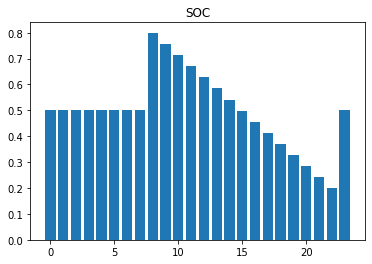

In [52]:
fig, ax = plt.subplots()
ax.bar(hours, socEss)
ax.set_title('SOC')

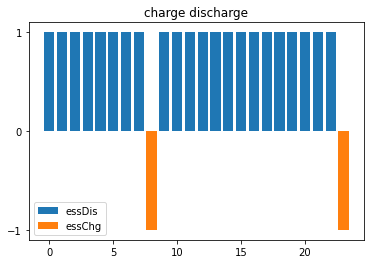

In [45]:
fig, ax = plt.subplots()
ax.bar(hours, U_essDisSol, label='essDis')
ax.bar(hours, -U_essChgSol, label='essChg')
ax.set_yticks([-1, 0, 1])  # note that we don't need to specify labels
ax.set_title('charge discharge')
ax.legend()